## Feature Extraction

In [2]:
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import time
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import random

2023-05-07 20:20:55.536695: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-07 20:20:55.680299: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-07 20:20:55.681378: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-07 20:20:56.444591: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [38]:
model = ResNet50(weights= 'imagenet', include_top = False,input_shape= (224,224,3))

In [39]:
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path,target_size=(input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features



In [40]:
features = extract_features('sample_images/cat.jpg',model)
len(features)

1/1 [==============================] - 0s 480ms/step


100352

In [41]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories,filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root,filename))
                counter +=1
    return file_list

In [19]:
num_images = len(filenames)

In [42]:
root_dir = 'caltech101'
filenames = sorted(get_file_list(root_dir))

In [46]:
feature_list = []
for i in tqdm_notebook(range(len(filenames))):
    feature_list.append(extract_features(filenames[i], model))

/tmp/ipykernel_229492/3169381920.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(filenames))):


  0%|          | 0/8677 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


In [47]:
pickle.dump(feature_list, open('features-caltech101-resnet.pickle', 'wb'))
pickle.dump(filenames, open('filenames-caltech101.pickle','wb'))

## Similarity Search

In [3]:
filenames = pickle.load(open('filenames-caltech101.pickle', 'rb'))
feature_list = pickle.load(open('features-caltech101-resnet.pickle', 'rb'))

In [11]:
import sklearn
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors = 5, algorithm = 'brute', metric = 'euclidean').fit(feature_list)
distances,indices = neighbors.kneighbors([feature_list[0]])

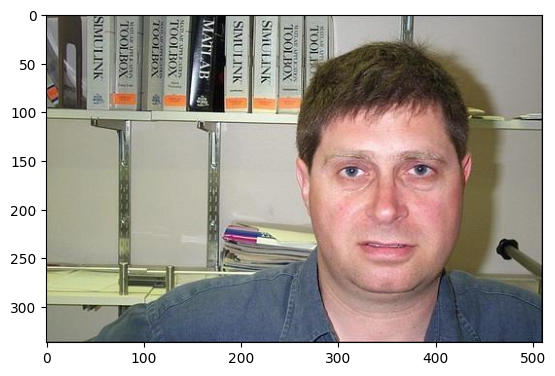

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.imshow(mpimg.imread(filenames[0]))

In [13]:
indices

array([[  0,  12,  18,   4, 366]])

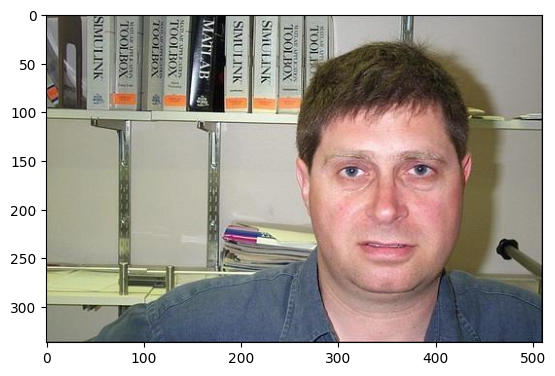

In [14]:
plt.imshow(mpimg.imread(filenames[indices[0][0]]))

In [15]:
for i in range(5):
    print(distances[0][i])

0.0
0.9479440992528938
0.9511412629326256
0.9592978903134961
0.9891944857453298


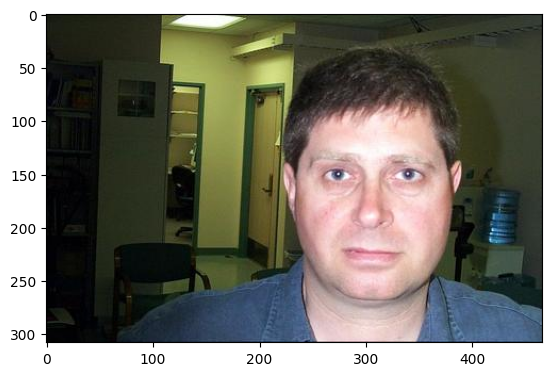

In [16]:
plt.imshow(mpimg.imread(filenames[indices[0][1]]))

In [24]:
# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]


# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]


def plot_images(filenames, distances):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 10))
    columns = 4
    for i, image in enumerate(images):
        ax = plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + classname_filename(filenames[i]))
        else:
            ax.set_title("Similar Image\n" + classname_filename(filenames[i]) +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))))
        plt.imshow(image)

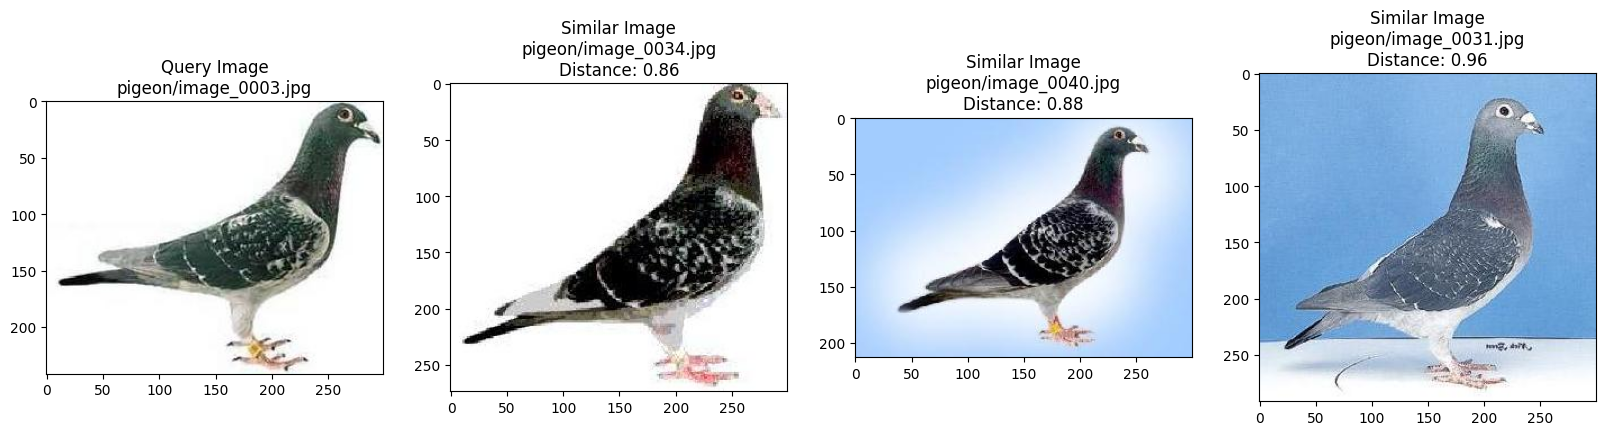

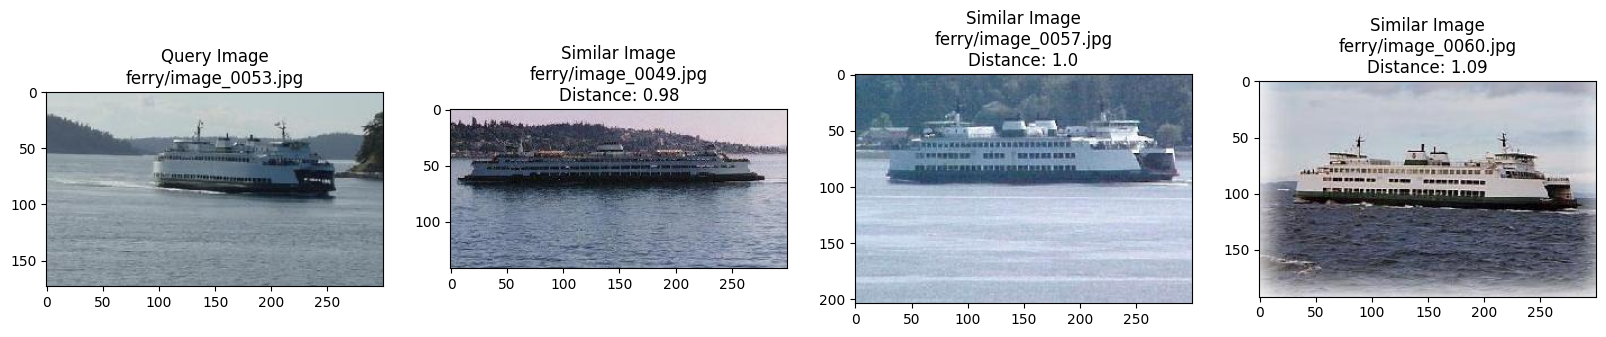

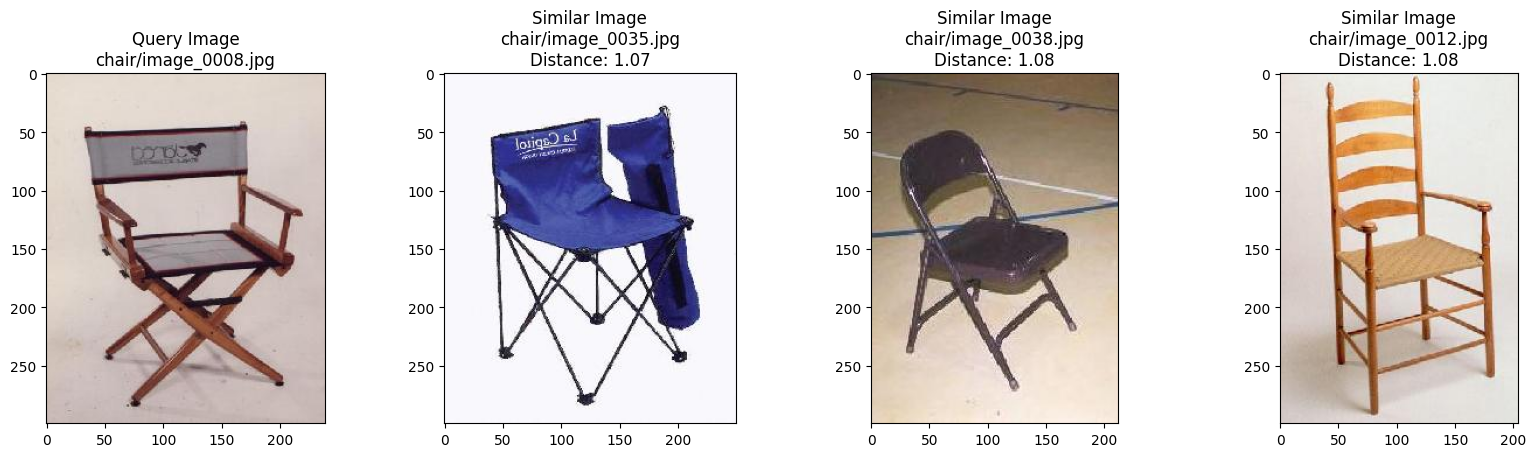

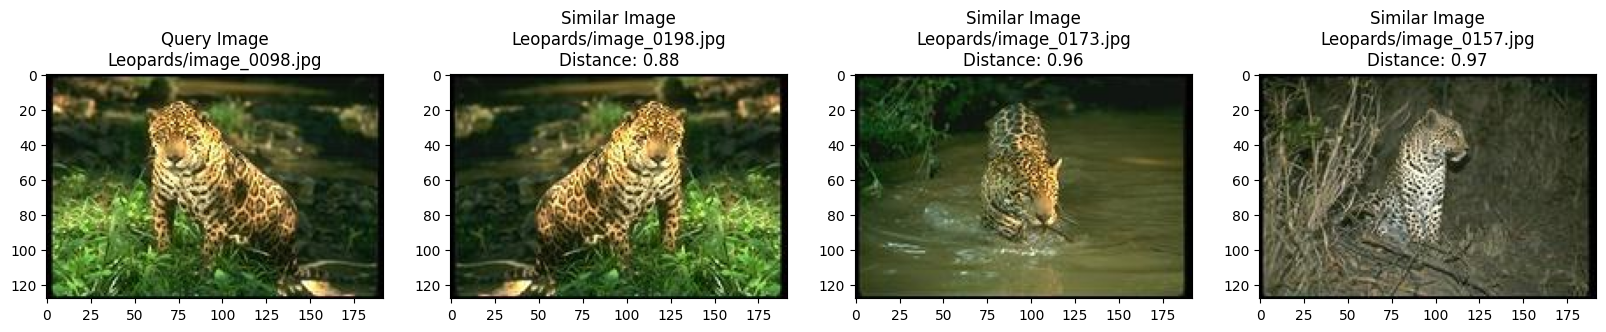

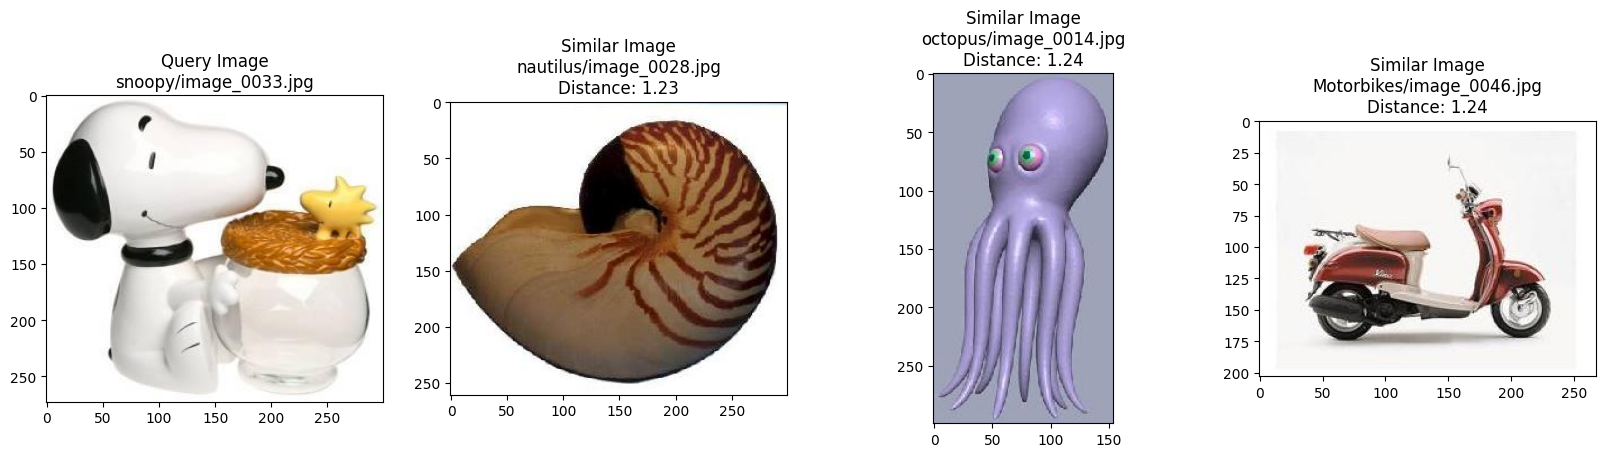

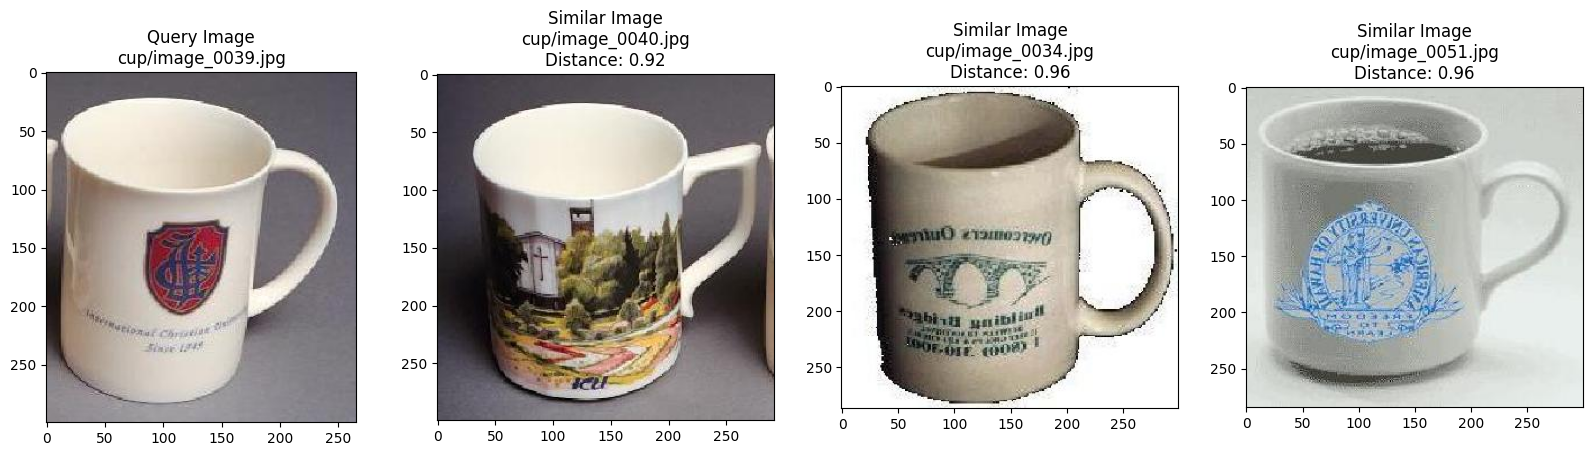

In [25]:
for i in range(6):
    random_image_index = random.randint(0, num_images)
    distances, indices = neighbors.kneighbors([feature_list[random_image_index]])
    similar_image_paths = [filenames[random_image_index]] + [filenames[indices[0][i]] for i in range(1,4)]
    plot_images(similar_image_paths, distances[0])